# Univariate Gaussian with Non-Constant Objective Function

In [19]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

from src.callback import Simulator
from src.output import OutputGenerator

## Hyperparameters

In [20]:
# random number generation
random_state = 42
mu = 3
var = 2
sample_size = 500

# optimisation
initial_guess = -4
method = "Nelder-Mead"

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

In [21]:
# set the random seed
rng = np.random.default_rng(random_state)

# generate a random sample using the numpy function
sample = rng.normal(mu, var, sample_size)

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


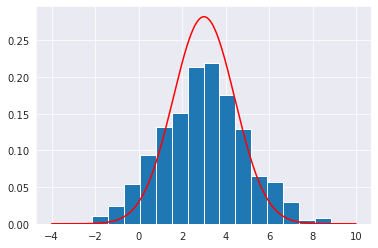

In [22]:
def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Setting $\mu$ to be a function of some parameters $a$, $b$

Let $\mu(a, b) = (a + 2b - 7)^{2} + (2a + b - 5)^{2}$

In [41]:
def non_constant_model(params, x):
    a, b = params
    return ((a + 2*b - 7)**2 + (2*a + b - 5)**2)

In [42]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = non_constant_model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

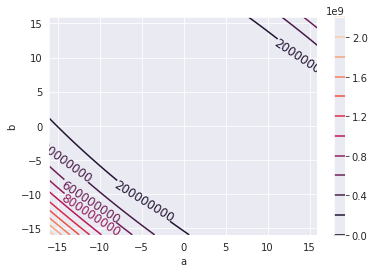

In [43]:
a = np.arange(-16, 16, .1)
b = np.arange(-16, 16, .1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)

likelihood_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    likelihood_values[idx] = likelihood(val, sample)
    
likelihood_values

contours = plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 10)
plt.clabel(contours, inline=1, fontsize=12)
plt.ylabel("b")
plt.xlabel("a")
plt.colorbar()

In [44]:
initial_guess = [10, 15]

likelihood_sim = Simulator(likelihood)

lik_model = minimize(likelihood_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 80
         Function evaluations: 167


In [45]:
callback = likelihood_sim.to_dataframe()

with pd.option_context('display.max_rows',10):
    print(callback)

    parameter 1  parameter 2    likelihood  iteration
0     10.000000    15.000000  2.465198e+08          1
1     10.500000    14.250000  2.342785e+08          2
2     10.750000    13.500000  2.121969e+08          3
3     10.250000    13.500000  1.920835e+08          4
4     10.125000    12.750000  1.600844e+08          5
..          ...          ...           ...        ...
35     0.580525     2.606605  1.035950e+03         36
36     0.580645     2.606484  1.035950e+03         37
37     0.580756     2.606372  1.035950e+03         38
38     0.580899     2.606229  1.035950e+03         39
39     0.580892     2.606236  1.035950e+03         40

[40 rows x 4 columns]


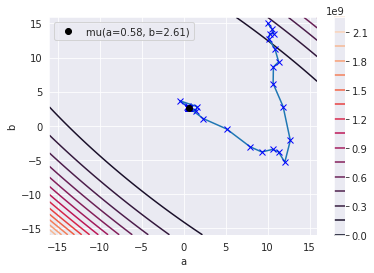

In [46]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.plot(callback["parameter 1"], callback["parameter 2"])
plt.plot(callback["parameter 1"], callback["parameter 2"], 'bx')
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()